# Customer Churn Prediction

**Problem Statement:** A bank wants to take care of customer retention for its product: savings account. The bank wants you to identify customers likely to churn balances belwo the minimum balance. You have the customers information such as age,gender,demographics along with their transactions with the bank.

Your task as data scientist would be to predict the propensity to churn for each customer.

In [26]:
#load the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, recall_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

**Reading the data**

In [3]:
df = pd.read_csv('churn_prediction.csv')

In [4]:
df.head()

customer_id  vintage  age gender  dependents     occupation    city  \
0            1     3135   66   Male         0.0  self_employed   187.0   
1            2      310   35   Male         0.0  self_employed     NaN   
2            4     2356   31   Male         0.0       salaried   146.0   
3            5      478   90    NaN         NaN  self_employed  1020.0   
4            6     2531   42   Male         2.0  self_employed  1494.0   

   customer_nw_category  branch_code  days_since_last_transaction  ...  \
0                     2          755                        224.0  ...   
1                     2         3214                         60.0  ...   
2                     2           41                          NaN  ...   
3                     2          582                        147.0  ...   
4                     3          388                         58.0  ...   

   previous_month_end_balance  average_monthly_balance_prevQ  \
0                     1458.71                        1458.71   
1                     8704.66                        7799.26   
2                     5815.29                        4910.17   
3                     2291.91                        2084.54   
4                     1401.72                        1643.31   

   average_monthly_balance_prevQ2  current_month_credit  \
0                         1449.07                  0.20   
1                        12419.41                  0.56   
2                         2815.94                  0.61   
3                         1006.54                  0.47   
4                         1871.12                  0.33   

   previous_month_credit  current_month_debit  previous_month_debit  \
0                   0.20                 0.20                  0.20   
1                   0.56              5486.27                100.56   
2                   0.61              6046.73                259.23   
3                   0.47                 0.47               2143.33   
4                 714.61               588.62               1538.06   

   current_month_balance  previous_month_balance  churn  
0                1458.71                 1458.71      0  
1                6496.78                 8787.61      0  
2                5006.28                 5070.14      0  
3                2291.91                 1669.79      1  
4                1157.15                 1677.16      1  

[5 rows x 21 columns]

In [5]:
df.shape

(28382, 21)

**Checking missing values**

In [6]:
df.isnull().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

**Dealing with missing values**

In [7]:
df['gender'].value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

In [8]:
dict_gender = {'Male': 1, 'Female':0}
df.replace({'gender': dict_gender}, inplace = True)

df['gender'] = df['gender'].fillna(-1)

#fill the missing values with -1.

In [9]:
df['dependents'].value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
36.0        1
52.0        1
25.0        1
9.0         1
50.0        1
32.0        1
8.0         1
Name: dependents, dtype: int64

In [10]:
df['occupation'].value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [11]:
df['dependents'] = df['dependents'].fillna(0)
df['occupation'] = df['occupation'].fillna('self_employed')

In [12]:
df['city'] = df['city'].fillna(1020)

In [13]:
df['days_since_last_transaction'] = df['days_since_last_transaction'].fillna(999)

For the city, occupation and dependents we have use mode to deal with missing values in the columns.

As we will be using linear model we have to scale the data and keep all features as numeric strictly.

# This is preprocessing part

In [14]:
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)

For scaling we have imported standard scaler module.

In [15]:
num_cols = ['customer_nw_category', 'current_balance',
            'previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit', 
            'previous_month_debit','current_month_balance', 'previous_month_balance']
for i in num_cols:
    df[i] = np.log(df[i] + 17000)

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

In [16]:
f_df_og = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [17]:
y_all = df.churn
df = df.drop(['churn','customer_id','occupation'],axis = 1)

Here i have used log transformation 

# Model Building

Before that we can make conclusions from EDA as follows:

* Debit values, we see that there is a significant difference in the distribution for churn and non churn and it might be turn out to be an important feature
* All the balance features the lower values have much higher proportion of churning customers
* Most frequent vintage values, the churning customers are slightly higher, while for higher values of vintage, we have mostly non churning customers which is in sync with the age variable
* See significant difference for different occupations and certainly would be interesting to use as a feature for prediction of churn.

As this is binary clasification problem, i will use **Recall** and **AUC-ROC** as evaluation metrics. 

In [18]:
baseline_cols = ['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']

In [19]:
df_baseline = df[baseline_cols]

In [20]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df_baseline,y_all,test_size=1/3, random_state=11, stratify = y_all)

In [21]:
model = LogisticRegression()
model.fit(xtrain,ytrain)
pred = model.predict_proba(xtest)[:,1]

**Evaluation Metrics**

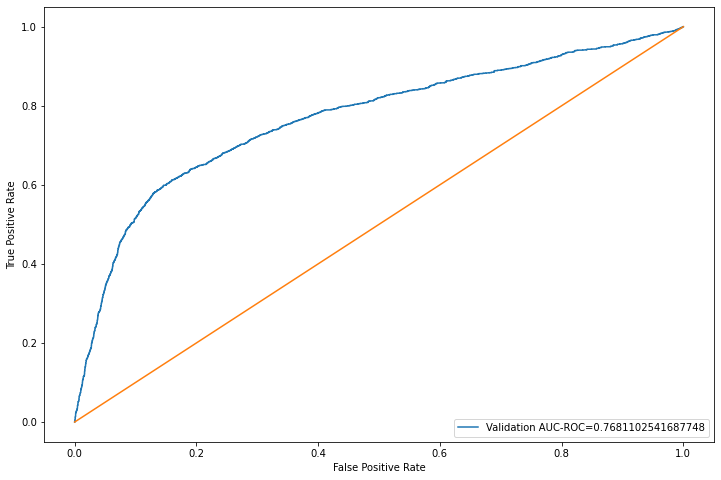

In [22]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,pred) 
auc = roc_auc_score(ytest, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [23]:
# Confusion Matrix
pred_val = model.predict(xtest)

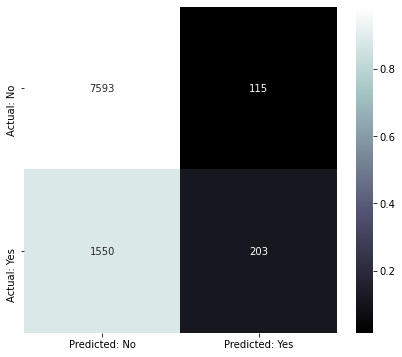

In [24]:
label_preds = pred_val

cm = confusion_matrix(ytest,label_preds)


def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'], cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

In [25]:
# Recall Score
recall_score(ytest,pred_val)

0.11580148317170565

**Conclusion**

Hence we can here see that the validation AUC-ROC score is : 0.76811
and the recall score is 0.1158.
So this can be improve by cross-validation if used further.